<center><h1>Explore the knowledge and trends of cannabis research<br>
    using K-mean clustering and text analysis</h1>

<center> Noa Maatuk and Michal Tel-Or

![title](images/cannabis.jpg)

# <a id='0' style=color:black>Table of Contents:</a>

1. [General overview](#1)
2. [Importing libraries](#2)
3. [Data description](#3)
4. [Data preparation](#4)
5. [Data cleaning](#5)
6. [Pre-processing of the texts](#6)
7. [Text analysis of canabis corpus](#7)
8. [Text clustering with K-Means](#8)
9. [Find the optimal Number of Clusters](#9)
10. [Auto-tagging based on cluster centers](#10)
11. [Plotting clusters](#11)
12. [Distribution of clusters over the last 20 years](#12)
13. [Conclusion](#13)

# <a id='1' style=color:black>1. General overview</a>

<p style='text-align: justify;'>
Cannabis refers to a group of three plants with psychoactive properties, known as Cannabis sativa, Cannabis indica, and Cannabis ruderalis and it is the most widely used illegal drug. On the one hand, there are known risks of using cannabis such as addiction, impairment of cognitive functions, anxiety, depression and mental health problems. On the other hand, cannabis holds much promise as a potential medicine for many ailments, each of which has its own state of research. The perception of medical usefulness together with increasing in popular support of cannabis use and a trend of cannabis legalization led to increase in medical cannabis research.
<br><br>To the best of our knowledge, there is by far no published work about the analysis of PubMed data related to cannabis.
<br><br><b>The aim of this study:</b>
<br>To analyze PubMed abstracts in order to highlight the various topics of cannabis research, those that indicates risk of using cannabis and those that indicate health benefits.
<br><b>The specific aims are:</b>
<br>-To use K-mean technique in order to categorize groups of research articles. This will allow to explore whether the information used in PubMed abstracts reflects the key concepts and the current understanding of cannabis uses.
<br>-To observe the trends of cannabis research over the 20 past years based on PubMed abstracts of papers related to cannabis, which would indicate general trends of research efforts.
</p>

[Back to top](#0)

# <a id='2' style=color:black>2. Importing Libraries</a>

In [43]:
# Data Structures
import pandas as pd
import numpy as np
import nbib

# Corpus Processing
import re
import nltk.corpus
from nltk.corpus                      import stopwords
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import CountVectorizer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize
from sklearn                          import preprocessing
import string
import joblib

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from wordcloud                        import WordCloud
from sklearn.metrics                  import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA


[Back to top](#0)

# <a id='3' style=color:black> 3. Data description</a>
<p style='text-align: justify;'>
Abstracts of the scientific publications that focusing on cannabis were searched and downloaded from PubMed, a free online search engine for biomedical literature database developed by the US National Center for Biotechnology Information (NCBI) (<a href="https://pubmed.ncbi.nlm.nih.gov/" target="_blank">https://pubmed.ncbi.nlm.nih.gov/</a>). 
<br><br>Retrieved studies had to contain in their title the word “cannabis” or its alternative names: dagga, ganja, hashish, hemp and marijuana.
<br><br>The results were restricted to scientific literature abstracts published during the last 2 decades (2001-2021) and to those that refer to human. We discarded articles that were not identified as English or that were not concluding abstract.
<br><br><b>The search query:</b>
<br><span style="font-family: 'Courier New', monospace;">
(("cannabis"[Title] OR "dagga"[Title] OR "ganja"[Title] OR "hashish"[Title] OR "hemp"[Title] OR "marijuana"[Title]) AND ("hasabstract"[All Fields] AND "humans"[MeSH Terms] AND ((fha[Filter]) AND (humans[Filter]) AND (english[Filter]) AND (2001:2021[pdat]))
</span>
<br><br>According to the search strategy, a total of 7,073 papers were included. 
<br>The results conlude various type of articles such as reviews, meta-analysis, survey, reports, research articles - academic and clinical research. 
</p>

[Back to top](#0)

# <a id='4' style=color:black>4. Data Preparation</a>
<p style='text-align: justify;'>
We downloaded the abstracts from the PubMed  website to one nbib file which its name is 'pubmed_cannabis_dataset.nbib'. 
<br>This file contains paragraphs of the abstracts category and their meta-information such as: authors, journal, year published, etc., that is, unstructured data.  
<br>In order to parse this text data to dictionary will use nbib library (<a href=https://pypi.org/project/nbib/target="_blank">https://pypi.org/project/nbib/target</a>). 
<br>The nbib file contain words that use non UTF-8 characters, so we'll read the as encoding to UTF-8 and copy it to a new file, ignoring errors. 
<br>Next, we'll use pandas to convert this dictionary to dataframe, which is the format we can work with.
</p>

In [44]:
# Read the nbib file
with open('pubmed_cannabis_dataset.nbib', 'r', encoding='utf-8', errors='ignore') as file:
    read_data = file.read()
file.close()

# Create a new nbib file that ignored from unwanted characters (characters that don't represented by UTF-8 characters)
file = open("pubmed_cannabis_dataset_2.nbib", "w", errors="ignore")
file.write(read_data)
file.close

# Convered the the unstructured data in the nbib file to python dictionary 
file_dict = nbib.read_file('pubmed_cannabis_dataset_2.nbib')

# Convered the python dictionary to dataframe
df = pd.DataFrame.from_dict(file_dict)

In [45]:
df.head()

pubmed_id citation_owner nlm_status last_revision_date electronic_issn  \
0   31447137            NLM    MEDLINE         2020-12-09       1942-5546   
1   29302228            NLM    MEDLINE         2018-11-13       1958-5969   
2   30522595            NLM    MEDLINE         2019-05-23       1942-5546   
3   31332738            NLM    MEDLINE         2019-09-11             NaN   
4   28983880            NLM    MEDLINE         2018-11-13       1534-6307   

  linking_issn journal_volume journal_issue publication_date  \
0    0025-6196             94             9         2019 Sep   
1    1294-8322             19             3         2017 Sep   
2    0025-6196             93            12         2018 Dec   
3    0065-2598           1162           NaN             2019   
4    1523-3774             19            11       2017 Oct 5   

                                             title  ... publication_status  \
0  Clinicians' Guide to Cannabidiol and Hemp Oils.  ...           ppublish   
1              Cannabis, cannabinoids, and health.  ...           ppublish   
2                                Medical Cannabis.  ...           ppublish   
3                Pharmacology of Medical Cannabis.  ...           ppublish   
4      Cannabis and Cannabinoids for Chronic Pain.  ...           epublish   

  print_issn      pmcid                                           keywords  \
0        NaN        NaN                                                NaN   
1  1294-8322  5741114.0  [cannabidiol, cannabis, medical cannabis, psyc...   
2        NaN        NaN                                                NaN   
3  0065-2598        NaN                [CBD, Cannabinoids, Medicinal, THC]   
4        NaN        NaN  [Marijuana, Medical cannabis, Medical marijuan...   

  conflict_of_interest grants secondary_source pmc-release_time  \
0                  NaN    NaN              NaN              NaT   
1                  NaN    NaN              NaN              NaT   
2                  NaN    NaN              NaN              NaT   
3                  NaN    NaN              NaN              NaT   
4                  NaN    NaN              NaN              NaT   

  corporate_author transliterated_title  
0              NaN                  NaN  
1              NaN                  NaN  
2              NaN                  NaN  
3              NaN                  NaN  
4              NaN                  NaN  

[5 rows x 40 columns]

In [46]:
print("Columns names:\n", df.columns)

Columns names:
 Index(['pubmed_id', 'citation_owner', 'nlm_status', 'last_revision_date',
       'electronic_issn', 'linking_issn', 'journal_volume', 'journal_issue',
       'publication_date', 'title', 'pages', 'abstract', 'copyright',
       'authors', 'language', 'publication_types',
       'electronic_publication_date', 'place_of_publication',
       'journal_abbreviated', 'journal', 'nlm_journal_id', 'descriptors',
       'received_time', 'revised_time', 'accepted_time', 'pubmed_time',
       'medline_time', 'entrez_time', 'pii', 'doi', 'publication_status',
       'print_issn', 'pmcid', 'keywords', 'conflict_of_interest', 'grants',
       'secondary_source', 'pmc-release_time', 'corporate_author',
       'transliterated_title'],
      dtype='object')


[Back to top](#0)

## Create new variable/column
We will extract the year from 'publication_date' to new column - 'publication_year'

In [47]:
df['publication_date'].head()

0      2019 Sep
1      2017 Sep
2      2018 Dec
3          2019
4    2017 Oct 5
Name: publication_date, dtype: object

In [48]:
# Create new column - publication_year
df['publication_year'] = ''
df['publication_year'] = df['publication_date'].str.split(" ",n=1, expand=True)
df['publication_year'].head()

0    2019
1    2017
2    2018
3    2019
4    2017
Name: publication_year, dtype: object

[Back to top](#0)

# <a id='5' style=color:black>5. Data Cleaning</a>

## Drop unnecessary columns

Since the goal of this analysis is to perform text analysis and clustering modeling, we will focus only on the text data from each abstract, and drop other metadata columns.

In [49]:
df = df.drop(columns=['place_of_publication','citation_owner','nlm_status','last_revision_date','electronic_issn','linking_issn','journal_volume','journal_issue','publication_date','pages','copyright','electronic_publication_date','journal_abbreviated','nlm_journal_id','received_time','revised_time','accepted_time','pubmed_time','medline_time','entrez_time','pii','doi','pmcid','publication_status','print_issn','conflict_of_interest','secondary_source','pmc-release_time','transliterated_title','keywords', 'authors','language','publication_types','journal','descriptors','grants','corporate_author'], axis=1)
df.head()

pubmed_id                                            title  \
0   31447137  Clinicians' Guide to Cannabidiol and Hemp Oils.   
1   29302228              Cannabis, cannabinoids, and health.   
2   30522595                                Medical Cannabis.   
3   31332738                Pharmacology of Medical Cannabis.   
4   28983880      Cannabis and Cannabinoids for Chronic Pain.   

                                            abstract publication_year  
0  Cannabidiol (CBD) oils are low tetrahydrocanna...             2019  
1  Cannabis (also known as marijuana) is the most...             2017  
2  Medicolegal realities surrounding "medical mar...             2018  
3  The Cannabis plant has been used for many of y...             2019  
4  PURPOSE OF REVIEW: The purpose of this study w...             2017

[Back to top](#0)

## Remove missing values
As one can see from the following command, there are no missing values in any of the columns.

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7073 entries, 0 to 7072
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   pubmed_id         7073 non-null   int64 
 1   title             7073 non-null   object
 2   abstract          7073 non-null   object
 3   publication_year  7073 non-null   object
dtypes: int64(1), object(3)
memory usage: 221.2+ KB


[Back to top](#0)

## Save and Load (optionally)

### Saving data to CSV file
One can choose to save the dataframe in .csv files for faster access during computational analyses.<br>
We'll use pandas to save the DataFrame to csv file

In [51]:
#df.to_csv('optional_files/cannabis_abstracts_clean.csv')
# Uncomment the following to save the file

### Loading data

We'll use pandas to read the csv file contaning the titles and abstracts for each PMID. 


In [52]:
#df = pd.read_csv('optional_files/cannabis_abstracts_clean.csv')
#df.head()
# Uncomment the following to load cannabis abstracts data

[Back to top](#0)

# <a id='6' style=color:black>6. Pre-processing of the texts</a>

## The corpus
The 'abstract' and 'title' columns fetched from Pubmed contain words in the format of sentences, therefore the data require pre-processing prior to text analysis. 
First, the abstracts and titles columns should be extracted and connected.

In [53]:
corpus = df['title']+df['abstract']
corpus = corpus.tolist()
corpus

["Clinicians' Guide to Cannabidiol and Hemp\xa0Oils.Cannabidiol (CBD) oils are low tetrahydrocannabinol products derived from Cannabis sativa that have become very popular over the past few years. Patients report relief for a variety of conditions, particularly pain, without the intoxicating adverse effects of medical marijuana. In June 2018, the first CBD-based drug, Epidiolex, was approved by the US Food and Drug Administration for treatment of rare, severe epilepsy, further putting the spotlight on CBD and hemp oils. There is a growing body of preclinical and clinical evidence to support use of CBD oils for many conditions, suggesting its potential role as another option for treating challenging chronic pain or opioid addiction. Care must be taken when directing patients toward CBD products because there is little regulation, and studies have found inaccurate labeling of CBD and tetrahydrocannabinol quantities. This article provides an overview of the scientific work on cannabinoids

In this stage we will convert unstructured text data into normalized and structured data using the Python NLTK (Natural Language Toolkit) library.
<br><br>
The text data pre-processing involves three steps:<br>
1) noise removal<br> 
2) normalization<br> 
3) tokenization<br>

[Back to top](#0)

## Noise removal

Data cleaning of our corpus done with processCorpus function which conclude few steps:

1. Lowercase the text.
2. Remove all words that don't contribute to the semantic meaning of the text (words that are not within the english alphabet (i.e e-mails and URLs). 
3. Remove punctuation.
4. Remove numbers. 
5. Remove stop words. The stop words are the most common words used in a language. In English, common stop words include “the”, “a”, “is”, “what“, “will“, “you“ etc. stop words also conclude connecting words that connect ideas together, for example, “and”, “but” and “so”.
6. Remove costum stop words that we define. The list conlude generic words that appear in the abstracts like: “abstract“, “background“, “results“, and “conclutions“.
7. Replace costum synonyms words that we define to avoid ambiguous terms - we'll replace synonyms words such as tetrahydrocannabinol and THC which are both names for the same chemical.
8. Removes any words composed of less than 2 or more than 21 letters.
9. Remove any excess white spaces

Returns cleaned list.


In [54]:
# Handling unwantes Symbols and Words
def processCorpus(corpus):
    
    stopwords = nltk.corpus.stopwords.words('english')    
    stopwords_costum = [line.rstrip('\n') for line in open('stopwords_costum.txt')] # Load .txt file line by line
    syn_dict = {'hemp':'cannabis','marijuana':'cannabis','dagga':'cannabis','ganja':'cannabis','hashish':'cannabis','women':'woman','female':'woman','men':'man','male':'man','children':'child','infants child':'infant','infants':'infant','cannabidiol':'cbd','cannabichromene':'cbc','cannabigerol':'cbg','tetrahydrocannabinol':'thc', }
    syn_keys=list(syn_dict.keys())
    
    for index, abstract in enumerate(corpus):

        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www
        
        corpus[index] = corpus[index].replace(u'\ufffd', '')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(u'\xa0', u'')    # remove '\xa0' a non-breaking space in Latin1 (ISO 8859-1)
        
        
        #corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        #corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
              
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        for c in string.punctuation:                            # Remove punctuation
            corpus[index]= corpus[index].replace(c," ")        

        
        corpus[index] = re.sub(r'young adult', 'young', corpus[index])
        corpus[index] = re.sub(r'first time', 'firsttime', corpus[index])
        corpus[index] = re.sub(r'over time', 'overtime', corpus[index])
        corpus[index] = re.sub(r'life time', 'lifetime', corpus[index])
        
        for syn in syn_keys:                                   
            corpus[index]=corpus[index].replace(syn, syn_dict[syn]) # replace synonyms
                
            
        corpus[index] = re.sub(' +', ' ', corpus[index])            # Remove Additional Spaces
        
        corpus[index] = ''.join(i for i in corpus[index] if not i.isdigit())  # removes numbers
            
        listOfTokens = word_tokenize(corpus[index])
        
        # removes a list of words (stopwords) from a tokenized list.
        listOfTokens = [w for w in listOfTokens if not w in stopwords]
        # removes a list of words (costom_words) from a tokenized list.
        listOfTokens = [w for w in listOfTokens if not w in stopwords_costum]
        
        # removes any words composed of less than 2 or more than 21 letters
        twoLetterWord = twoLetters(listOfTokens)
        listOfTokens = [w for w in listOfTokens if not w in twoLetterWord]
        
        corpus[index]   = " ".join(listOfTokens)
        #corpus[index] = unidecode(corpus[index])   
        
    return corpus

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) < 3 or len(token) >21:
            twoLetterWord.append(token)
    return twoLetterWord



In [55]:
# Display the results before we apply processCorpus function
corpus[18]

'Marijuana, phytocannabinoids, the endocannabinoid system, and male fertility.Marijuana has the highest consumption rate among all of the illicit drugs used in the USA, and its popularity as both a recreational and medicinal drug is increasing especially among men of reproductive age. Male factor infertility is on the increase, and the exposure to the cannabinoid compounds released by marijuana could be a contributing cause. The endocannabinoid system (ECS) is deeply involved in the complex regulation of male reproduction through the endogenous release of endocannabinoids and binding to cannabinoid receptors. Disturbing the delicate balance of the ECS due to marijuana use can negatively impact reproductive potential. Various in vivo and in vitro studies have reported on the empirical role that marijuana plays in disrupting the hypothalamus-pituitary-gonadal axis, spermatogenesis, and sperm function such as motility, capacitation, and the acrosome reaction. In this review, we highlight 

In [56]:
corpus = processCorpus(corpus)

In [57]:
# Check the results of processCorpus function
corpus[18]

'cannabis phytocannabinoids endocannabinoid man fertility cannabis highest consumption rate illicit drugs usa popularity recreational medicinal drug increasing man reproductive age man factor infertility increase exposure cannabinoid compounds released cannabis contributing endocannabinoid ecs deeply involved complex regulation man reproduction endogenous release endocannabinoids binding cannabinoid receptors disturbing delicate balance ecs cannabis negatively impact reproductive potential vivo vitro empirical role cannabis plays disrupting hypothalamus pituitary gonadal axis spermatogenesis sperm function motility capacitation acrosome reaction highlight latest cannabis man fertility provide detailed insight ecs man reproductive'

[Back to top](#0)

## Normalizing the text

Normalizing of our corpus done with normalizeCorpus function.

Normalization refers to stemming. Stemming is a technique that reduces a word to it's root. <br>
The root form is not necessarily a word by itself, but it can be used to generate words by concatenating the right suffix. For example, the words study, studies and studying stems into studi, which is not an English word. But its allow to Keep all of the remaining words in the simplest format possible, so we can apply a function that gives weights to each word. 

Returns normalized list.

In [58]:
# Normalizing the text
def normalizeCorpus(corpus):
    param_stemmer = SnowballStemmer('english')
    for index, document in enumerate(corpus):
        listOfTokens = word_tokenize(corpus[index])
        # applies stemming to a list of tokenized words
        listOfTokens = [param_stemmer.stem(w) for w in listOfTokens]       
        # removes any words composed of less than 2 or more than 21 letters
        twoLetterWord = twoLetters(listOfTokens)
        listOfTokens = [w for w in listOfTokens if not w in twoLetterWord]
        corpus[index]   = " ".join(listOfTokens)
    return corpus

In [59]:
corpus = normalizeCorpus(corpus)

In [60]:
# Check the results of normalizeCorpus function
corpus[18]

'cannabi phytocannabinoid endocannabinoid man fertil cannabi highest consumpt rate illicit drug usa popular recreat medicin drug increas man reproduct age man factor infertil increas exposur cannabinoid compound releas cannabi contribut endocannabinoid deepli involv complex regul man reproduct endogen releas endocannabinoid bind cannabinoid receptor disturb delic balanc cannabi negat impact reproduct potenti vivo vitro empir role cannabi play disrupt hypothalamus pituitari gonad axi spermatogenesi sperm function motil capacit acrosom reaction highlight latest cannabi man fertil provid detail insight man reproduct'

[Back to top](#0)

## Tokenizing the text
Tokenization is used to split the sentences into words (tokenization).<br>
This stage concluded in the following function - TfidfVectorizer, which among other things, convert a collection of text documents to a matrix of token.

[Back to top](#0)

## Feature weighting

In this stage we will convert the tokenized abstracts into a matrix that will serve as an input for clustering model. This process is referred to “vectorization”.

The tokenized object will be vectorized using the Term Frequency - Inverse Document Frequency (TF-IDF) method. The TF-IDF is a feature Statistical weighting of Words algorithm that calculate the importance of words in each abstract relative to what is in that abstract but also relative to all the abstracts in the corpus. This normalization increases the importance of words that appear multiple times in the same abstract while decreasing the importance of words that appear in many abstracts (which would mostly be generic terms). TF-IDF give each word in an abstract a score that ranges from zero to one.

TFIDF Vectorizer (TfidfVectorizer) will be used with its default parameters.

The finall corpus is a feature matrix.

In [61]:
# Function that runs the TF-IDF function and returns a vector and dataframe of  weighting words
def TfidFun(corpus):   
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    tf_final = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

    return X, tf_final, vectorizer

[Back to top](#0)

# <a id='7' style=color:black>7. Text analysis of canabis corpus</a>

In this section we will use exploratory analysis tools to aggregate and visualize the text data associated with cannabis. 
<br>

We’ll make a bar plot and word cloud using matplotlib the wordcloud package to get a visual representation of the most frequent occurring words in the abstracts that were related to cannabis. 

In [62]:
# Join all abstracts together
corpuse_all=[(" ".join(corpus))]
corpuse_all

['clinician cbd cannabisoil cbd cbd oil low thc product deriv cannabi sativa popular relief varieti condit pain intox advers effect medic cannabi june cbd drug epidiolex approv food drug administr treatmant rare sever epilepsi put spotlight cbd cannabi oil grow bodi preclin clinic support cbd oil condit suggest potenti role option treat challeng chronic pain opioid addict care direct cbd product regul inaccur label cbd thc quantiti work cannabinoid cbd cannabi oil distinct cannabi cannabi compon cbd cannabi oil product legal status cbd cannabi oil unit state provid identifi higher qualiti product clinician advis safest formul pubm term cbd cbd cannabi oil medic cannabi screen select inclus cannabi cannabinoid health cannabi cannabi frequent illicit psychoact substanc long consid soft drug proven harm psychiatr addict effect number elem respons increas complic cannabi includ increas potenc cannabi evolut primari compon thc thc cbd higher proport thc synthet cannabinoid rapid progress fr

In [63]:
# Call to TF-IDF function to create vector and dataframe of  weighting words for  all abstracts
X_all, tf_final_all, vectorizer_all = TfidFun(corpuse_all)

We will used the command X.toarray(), to print the matrix (and not just X).
The reason is that since there are many features, but only a few of them are represented in each absrtract, sklearn choses to store the matrix as a "sparse matrix" - which has much more efficient memory footprint (but it's print is different than regular matrix).
Therefore, we transformed it into a two dimensional array and printed it.

In [64]:
X_all.toarray()

array([[4.77599643e-05, 1.43279893e-04, 1.59199881e-05, ...,
        1.59199881e-05, 1.59199881e-05, 1.59199881e-05]])

Each row represents an abstract, and each column represents a feature (a word). (Here all abstracts are concatenate, so there is only one row). Each word in an abstract get a TF-IDF score that ranges from zero to one. This number represents how many times each of the features appear in this abstract.

In [65]:
# print the feature names (and order of columns)
print(vectorizer_all.get_feature_names())

['aab', 'aac', 'aacr', 'aad', 'aaem', 'aah', 'aama', 'aamc', 'aao', 'aap', 'aapc', 'aasm', 'aat', 'abac', 'abacad', 'abacada', 'abandon', 'abat', 'abatem', 'abbrevi', 'abc', 'abca', 'abcb', 'abcd', 'abcg', 'abdoman', 'abdomin', 'aberr', 'abh', 'abi', 'abid', 'abiet', 'abil', 'ablat', 'abm', 'abnorm', 'abolish', 'abolit', 'aborigin', 'abort', 'abound', 'abram', 'abras', 'abroad', 'abrog', 'abrupt', 'abscess', 'absenc', 'absent', 'absente', 'absolut', 'absorb', 'absorpt', 'absorptiometri', 'abstain', 'abstent', 'abstin', 'abstract', 'abstractbackground', 'abt', 'abund', 'abus', 'abuzaid', 'acad', 'academ', 'academi', 'academia', 'acaricid', 'acasi', 'acc', 'acceler', 'accelerometri', 'accent', 'accentu', 'accept', 'access', 'accid', 'accident', 'accommod', 'accompani', 'accomplish', 'accomplishm', 'accord', 'account', 'accredit', 'accru', 'accrual', 'accu', 'accultur', 'accumben', 'accumul', 'accur', 'accuraci', 'accus', 'accusatori', 'accustom', 'accutof', 'acdc', 'ace', 'acet', 'acetal

In [66]:
# Print the first 5 words with highest weight on document 0:
x_all=tf_final_all.T.nlargest(5, 0)
print(x_all.index.tolist())

['cannabi', 'effect', 'alcohol', 'drug', 'increas']


In [67]:
#totalWord=np.sum(X_all)
#print("total words",totalWord)
totalUniqueWords=X_all.shape[1]
print("total unique words",totalUniqueWords)

#you could also get it by this:
print("total unique words (take 2)",len(vectorizer_all.get_feature_names()))
print("first 20 features:",vectorizer_all.get_feature_names()[:20])

total unique words 14369
total unique words (take 2) 14369
first 20 features: ['aab', 'aac', 'aacr', 'aad', 'aaem', 'aah', 'aama', 'aamc', 'aao', 'aap', 'aapc', 'aasm', 'aat', 'abac', 'abacad', 'abacada', 'abandon', 'abat', 'abatem', 'abbrevi']


In [68]:
# create a dictionary from the first (and only) row
freq_vec=X_all.toarray()
freqDist=dict(zip(vectorizer_all.get_feature_names(),freq_vec[0])) # create a dictionary from the first (and only) row
freqDist=dict(sorted(freqDist.items(), key=lambda item: item[1],reverse=True)) # ascending sort..
freqDist

{'cannabi': 0.8898954941085683,
 'effect': 0.0953925686196025,
 'alcohol': 0.09189017124037811,
 'drug': 0.09052105226486312,
 'increas': 0.08564953591012375,
 'risk': 0.08496497642236625,
 'adolesc': 0.08073025959112222,
 'age': 0.08025265994850071,
 'medic': 0.07682986250971323,
 'thc': 0.0752219437128875,
 'substanc': 0.07412346453485802,
 'disord': 0.07229266590480891,
 'treatmant': 0.06883802848984667,
 'depend': 0.058633316125833786,
 'associ': 0.05856963617348425,
 'health': 0.057582596912066464,
 'smoke': 0.05478067900868695,
 'symptom': 0.05301356033098738,
 'tobacco': 0.04900172333296671,
 'state': 0.04838084379755875,
 'includ': 0.04688436491734469,
 'high': 0.0442575668829264,
 'factor': 0.04303172780019786,
 'level': 0.041455648979546886,
 'differ': 0.04112132922971183,
 'legal': 0.04002285005168236,
 'woman': 0.038812930957041206,
 'control': 0.03849453119529354,
 'individu': 0.037443811981526215,
 'problem': 0.03688661239846779,
 'cannabinoid': 0.036711492529506576,
 'ab

## Word distribution plot
In order to see the top words and their relative frequencies, we'll create a bar chart.

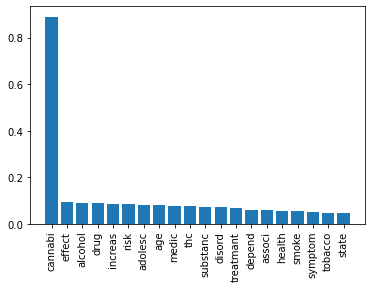

In [69]:
topK=20
plt.bar(list(freqDist.keys())[:topK], list(freqDist.values())[:topK])
plt.xticks(list(freqDist.keys())[:topK], rotation='vertical')
plt.show()

[Back to top](#0)

## WordClouds
WordCloud is a technique that shows which words are the most frequent among the given text. 
we'll create wordcloud for all abstracts together using the top 75 words, based on the word frequencies dictionary:

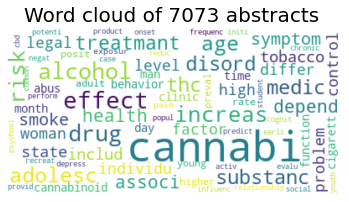

In [70]:
#width = 4000, height = 1000, random_state=77,
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=75, background_color="white").generate_from_frequencies(freqDist)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word cloud of 7073 abstracts ", fontsize=20)
plt.axis("off")
plt.show()

This representation allow us to understanding the data, to verify the preprocessing stage, ensuring we are on the right track or altertatively consider if any more preprocessing is necessary before training the model.
As presented by the word cloud, the most frequently occurring words include “cannabis”, “alcohol”, “drug”, “treatmant”, “depend”, “risk”, “age”, “thc”. Those are in line with the expectations for the publications around the cannabis, since those key words basically either define the cannabis characteristics or are related to the cannabis useages.

[Back to top](#0)

# <a id='8' style=color:black>8. Text Clustering with K-Means</a>

We have no prior knowledge with regards to the groups of our abstracts. In order to find structure in our unlabelled abstracts we should use unsupervised learning techniqe. 

Here we will use k-means algorithm, a simple and popular unsupervised clustering algorithm, in order to find groups of similar abstracts in our corpus.

k-means algorithm calculate the distance between the points (abstracts) and group nearby abstracts together indicated that tey are similiar.

The K-Mean model will built with the KMeans function in the Python sklearn library.

## 'perform_k_means' function
This function Perform multiple K-means clustering.
In our case, the regular Kmeans implementation is too slow to run on laptop, so we use the MiniBatchKMeans algorithm. MiniBatchKMeans introduces some noise so we raised the batch and init sizes higher. 
We also set the following parameters:
data - the dataset to run the K-means clustering on.
max_k – the maximum range of clusters
num_clusters - the number of clusters to set the 'n_clusters' parameter with
All other parameters remain the default values

After the k-means model object will created, the command fit will be used to get the trained model and predicted values.

Returned values:
model - the trained k-means model
predicted_vals - the predicted values, corresponding to each row in the given input dataset.


In [71]:
#Function that runs the K-Means algorithm max_k times and returns a dictionary of each k result
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):       
        kmeans = cluster.MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300, batch_size=2048, random_state=42, init_size=1400, n_init=20)      
        kmeans_results.update( {k : kmeans.fit(data)} )        
    return kmeans_results

## Create K-means models

In [72]:
# Feature weighting
X, tf_final, vectorizer = TfidFun(corpus)

In [73]:
# Running Kmeans 19 times from K=2 to K=20 in order to calculate different models of abstracts clustering
k = 20
#kmeans_results = run_KMeans(k, tf_final)

In [80]:
# Saving the models
#filename = 'optional_files/finalized_kmean_model.sav'
#joblib.dump(kmeans_results, filename)

In [104]:
# load saved models from local directory
filename = 'optional_files/finalized_kmeans_models.sav'
kmeans_results = joblib.load(filename)

[Back to top](#0)

# <a id='9' style=color:black>9. Find the Optimal Number of Clusters</a>

Now we just have to figure out the optimal number of clusters to choose when running K-means algorithm using the given input parameters.
A good cluster is one with the distance between the points within the cluster less than the distance between points of two different clusters.

We evaluate for the optimal number of clusters using two predominant methods<br>
· Elbow method<br>
· Average Silhouette method

## Elbow method

In this method, we will calculate and plot the SSE for a range of cluster sizes and we will look for the value of  k  at which the total intra-cluster distance (SSE) tapers off, and creates line chart resembles an arm. the “elbow” (the point of inflection on the curve) is generally considered as an indicator of the appropriate number of clusters.

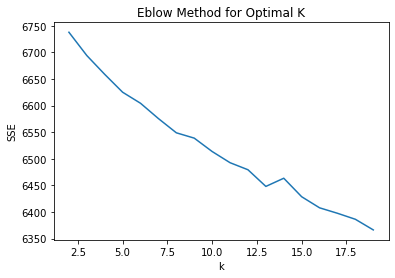

In [90]:
ks = range(2,20)
scores = []

for k in ks: 
    scores.append(kmeans_results[k].inertia_)
            
plt.plot(ks, scores)
plt.title('Eblow Method for Optimal K')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

In our case the "elbow" cannot be unambiguously identified. We can see from the figure that a more than one elbows have been generated. However, we choose eight  as the optimal number of clusters since eight  is where elbow form, such as adding another cluster is minimally improves the total SSE (relatively).

[Back to top](#0)

## Silhouette Score
Another method for clustering evaluation is silhouette_score. The silhouette value is a measure of how similar an abstract is to its own cluster (cohesion) compared to other clusters (separation).

In [92]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

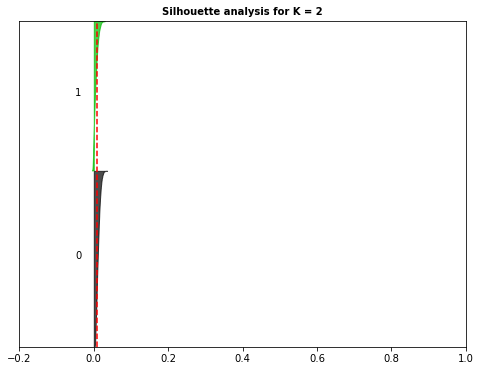

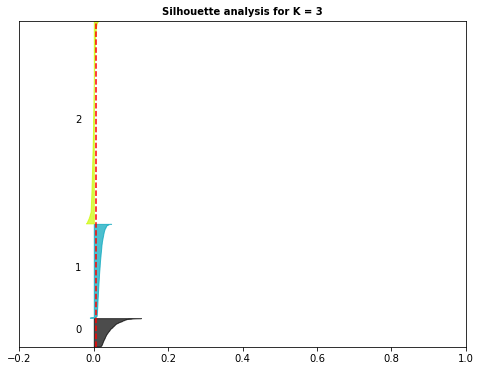

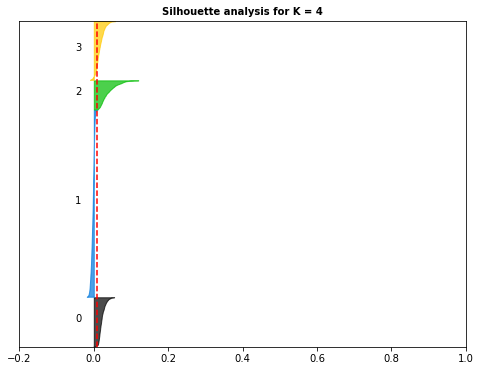

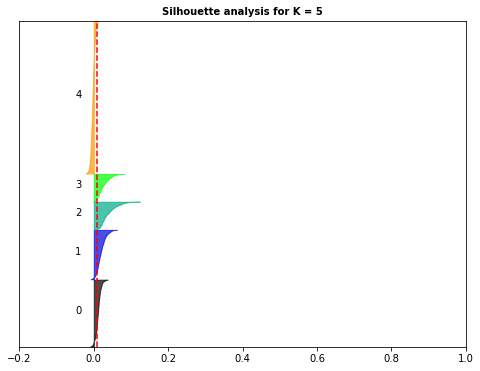

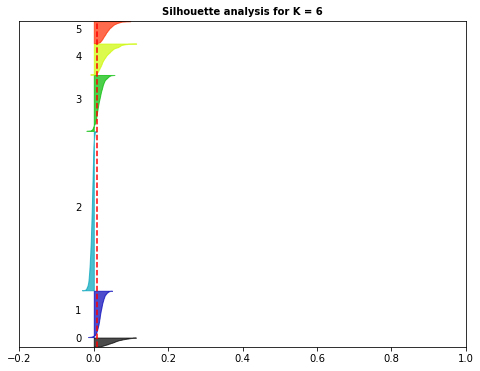

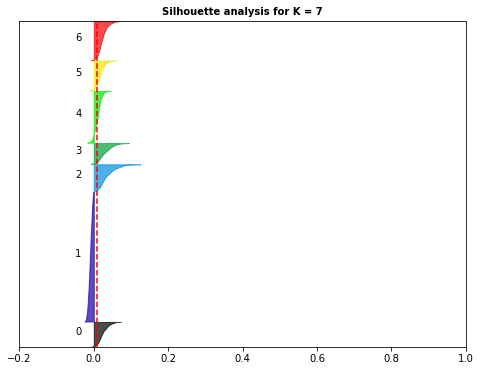

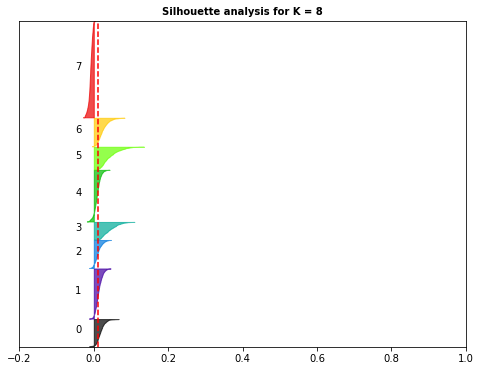

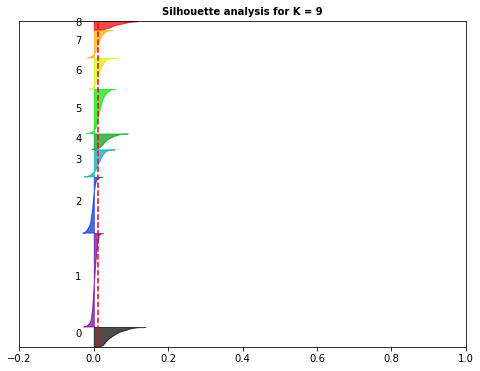

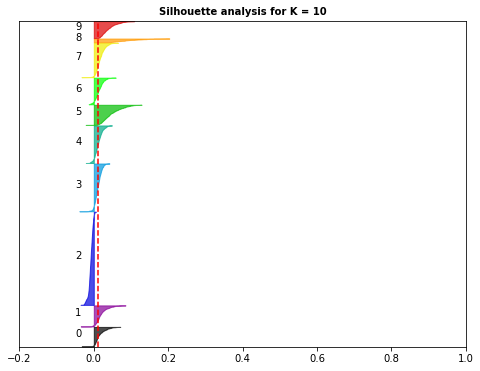

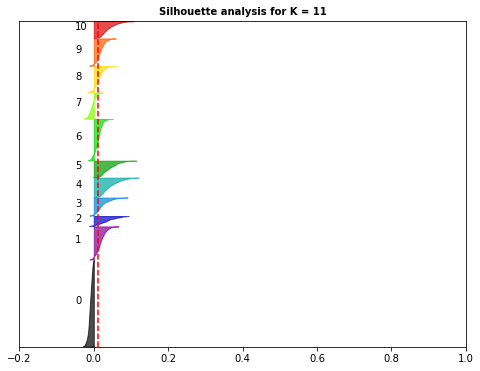

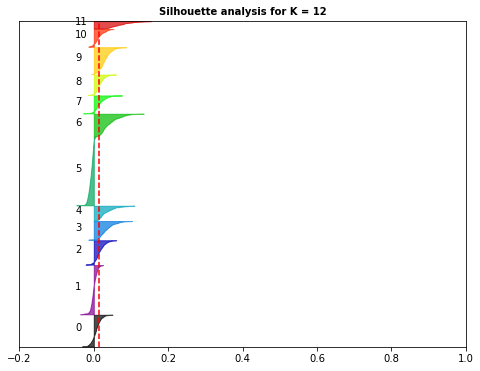

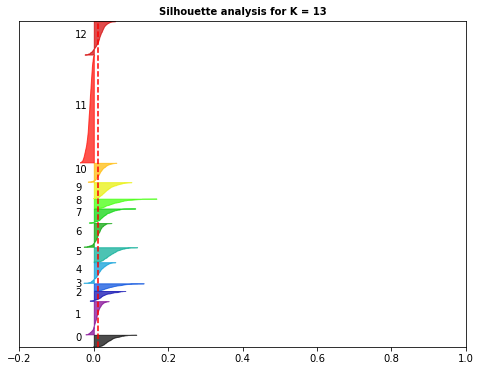

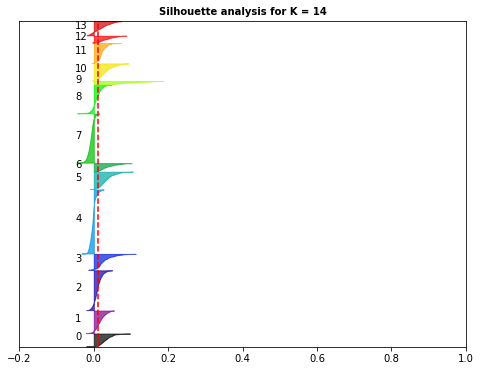

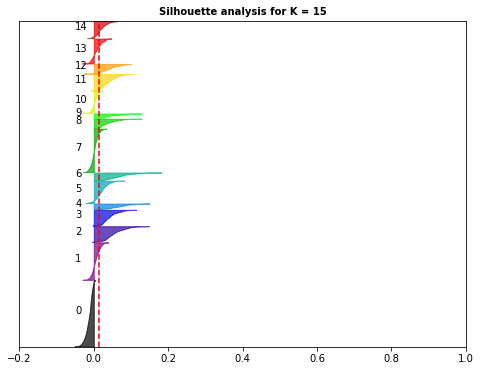

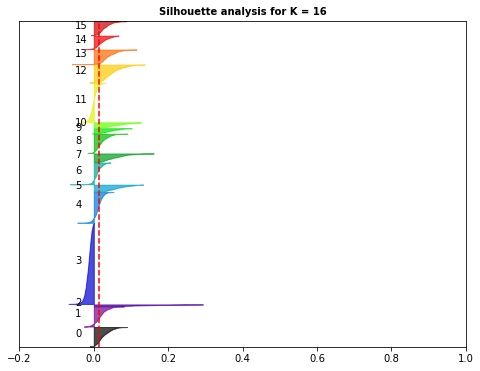

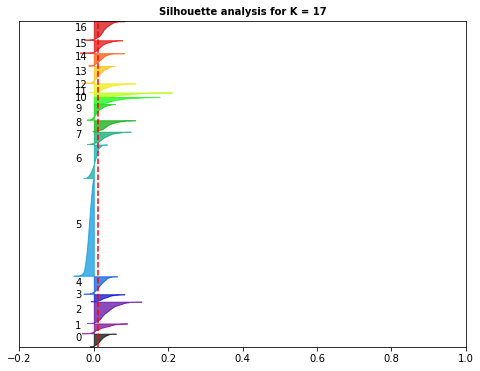

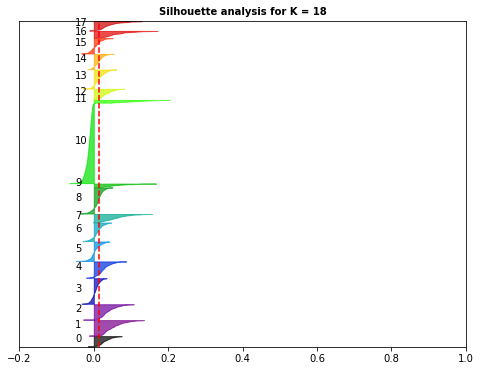

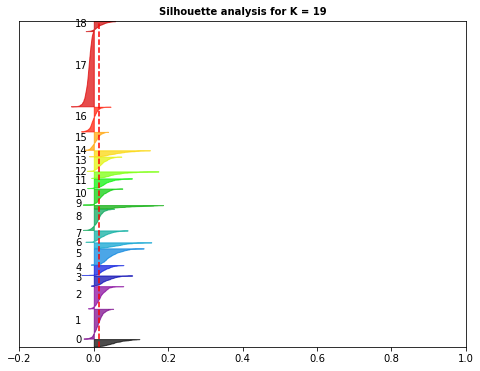

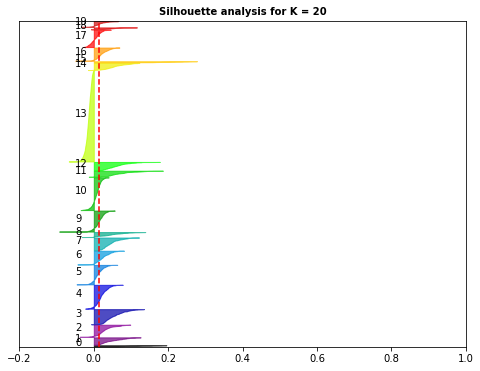

In [93]:
# Plotting Silhouette Analysis
silhouette(kmeans_results, tf_final, plot=True)

In [94]:
# Alternatively, uncomment the following to print only the Silhouette Score
#ks = range(2,15)
#for k in ks:
#    kmeans = kmeans_results.get(k)
#    tf_final_array = tf_final.to_numpy()
#    prediction = prediction = kmeans.predict(tf_final)
#    print("Number of clusters=",k,"\tsilhouette_score =",silhouette_score(X, prediction),"\n")

As one can see, the silhouette_score for all number of k is lower than 5, indicates that none of the division into clusters are not good. Namely, The improvement in k=3 that displaied in eblow method is not visible in the Silhouette score. 
Since Silhouette score suffer from the phenomenon called Curse of Dimensionality” for high dimensional datasets such as text data, we choose to ignore from this evaluation.
As more than one elbows have been generated, We will select right amount of clusters by trial and error. 

[Back to top](#0)

## Text analysis for each cluster

We look at eight the clusters generated by k-means.
In order to evaluate the resulting categorization, ten top key words, based on their TFIDF score, are presented for each cluster. 

In [105]:
# Print the most dominant words in each cluster at the 8 clusters generated by k-means.
best_result = 8
kmeans_best_result = kmeans_results.get(best_result)
words = vectorizer.get_feature_names()
common_words = kmeans_best_result.cluster_centers_.argsort()[:,-1:-15:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : cannabi, cognit, brain, function, memori, schizophrenia, adolesc, task, perform, effect, activ, control, deficit, abstin
1 : cannabi, disord, psychosi, symptom, cud, depress, psychot, risk, anxieti, depend, problem, motiv, associ, schizophrenia
2 : cannabi, legal, state, polici, recreat, health, public, medic, law, increas, harm, product, colorado, regul
3 : tobacco, cigarett, smoke, cannabi, smoker, lung, nicotin, increas, young, cessat, alcohol, product, substanc, youth
4 : cannabi, adolesc, alcohol, substanc, age, risk, school, parent, student, earli, initi, drug, youth, associ
5 : thc, cbd, cannabi, concentr, cannabinoid, oral, delta, dose, effect, smoke, blood, detect, placebo, thccooh
6 : medic, cannabi, pain, opioid, medicin, state, cancer, chronic, effect, legal, cannabinoid, treatmant, prescript, health
7 : cannabi, treatmant, drug, depend, effect, case, withdraw, cannabinoid, clinic, cocain, increas, risk, abus, symptom


## Examining the top words in each cluster

In this section, we are going to look at the results we got.<br> 
<u>Cluster 0: </u> words such as ‘cognit’, ‘brain’, ‘function’, ‘memori’, ‘task’ and ‘perform’,
related to <b>cognitive dysfunction</b>.<br> 
<u>Cluster 1: </u> words such as ‘CUD’, ‘disord’ and ‘depend’ are related to cannabis use disorder (CUD). The symptoms of CUD are ‘anxiety’, ‘depress’ and ‘psychosis’ and the treatment conclud ‘psychological’ intervention. Thus, the words in this cluster related to <b>cannabis use disorder (CUD) </b>.<br> 
<u>Cluster 2: </u>words such as ‘legal’, ‘polici’, ‘public’ and ‘regul’ are related to <b>cannabis policy</b>. Cannabis policy refers to ‘health’ and ‘harm’ and also to ‘medical’ cannabis.<br> 
<u>Cluster 3: </u>words such as ‘tobacco’, ‘cigarett’, ‘smoke’, ‘nicotin’, suggest the connection between cannabis use and  tobacco smoking. Cannabis smoking increases the likelihood to ‘lung’ cancer, however a lot of those who smoke cannabis, smoke also tobacco, so this may be the reason of this ‘increase’. In addition, smoking tobacoo increase the likelihood to use cannabis. Cannabis use and tobacco smoking also come with other ‘substanc’ like ‘alcohol’. In general, this cluster reffer to <b>cannabis and tobacco</b>.<br> 
<u>cluster 4: </u>word such as ‘adolesc’, ‘youth’, ‘parent’, ‘school’, ‘alcohol’, ‘substanc’, ‘drug’ can reffer to cannabis use motives. This includes frequent use at a young age, poor parenting, school drop-out, alcohol and drug-using. Thus, the words in this cluster related to <b>cannabis use motives</b>.<br> 
<u>Cluster 5: </u>’thc’ and ‘cbd’ are the two of the most prominent cannabinoids found in the cannabis plant. Their ‘concentrations’/’doses’ have different ‘effects’ and they are ‘detected’ in the ‘blood’. Thus, the words in this cluster related to <b>Cannabinoids THC and CBD</b>.<br> 
<u>Cluster 6: </u>words such as ‘medic’, ‘medicin’, ‘prescript’, ‘treatmant’, ‘pain’, ‘chronic’, ‘cancer’ and ‘opioid’ related to <b>medical cannabis</b>.<br> 
<u>Cluster 7: </u>word such as ‘depend’, ‘withdraw’, ‘treatment’ and ‘symptom’ refer to cannabis addiction and treatment. Words like ‘drug’ and ‘cocain’ may refer to other addictions. Thus, the words in this cluster related to <b>cannabis addiction treatment</b><br> 
<br> 
That is, it can be seen that there is commonalities between words in each cluster.

[Back to top](#0)

## Visualisation of top words
Few words appear in more than one cluster such as ‘schizophrenia’, ‘medic’, ‘alcohol’, ‘risk’, ‘smoke’, ’legal’, ‘treatment’ and ‘depend’.
Their meaning may depend on the context. i.e. ‘treatment’ this could be medical treatment or cannabis rehab.
<br> 
But it is also likely as well that the corpus therefore contains overlapping clusters. I.e. ‘schizophrenia’ appears in cluster 0 - cognitive function and also in cluster 1 - cannabis use disorder (CUD).
On the one hand, there is an  association between cannabis use and schizophrenia and therefore its likely that schizophrenia appears in the cluster of cannabis use disorder (CUD). On the other hand, schizophrenia is a mental disorder which among others includes cognitive problems. Thus, It is therefore likely that schizophrenia appears in the cluster of cognitive function.
<br>
Below are eight graphs corresponding to the top 15 words in each cluster ordered by relative importance as measured by TF-IDF. This allows us to take a deeper look at each cluster. While the score of ‘schizophrenia’ in cluster 0 - cognitive function is 0.05, it’s score in cluster 1 - cannabis use disorder (CUD) is 0.035. That is, ‘schizophrenia’ more dominant in cognitive function.

In [96]:
# Produce simple bar plots to look at the most dominant words in each cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

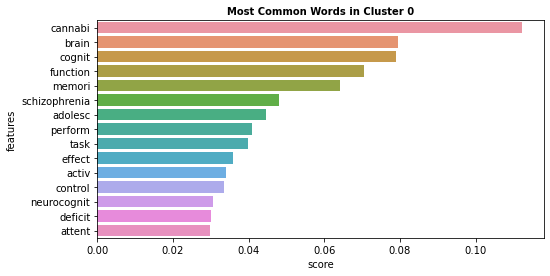

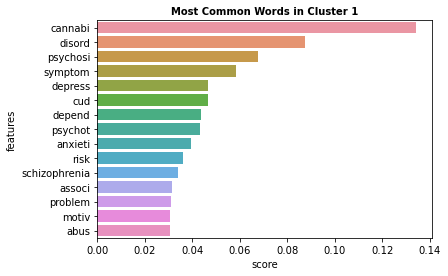

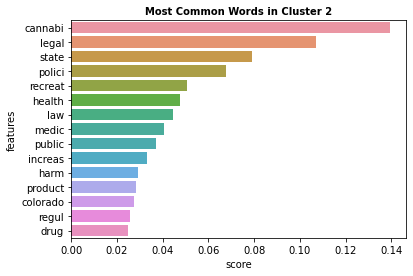

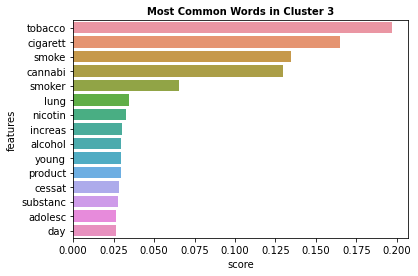

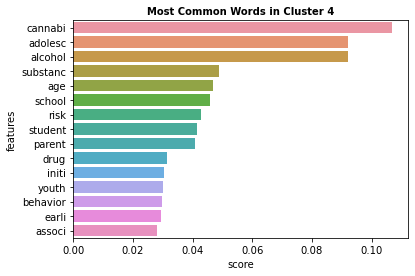

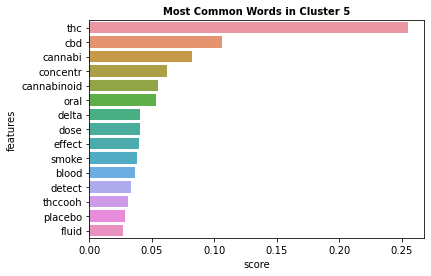

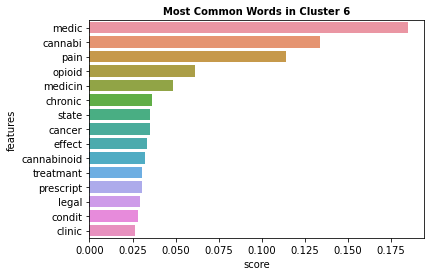

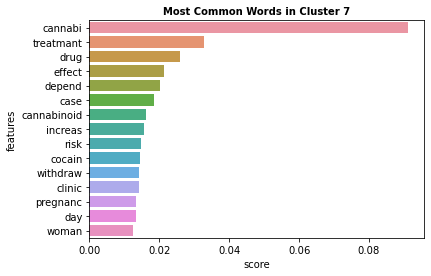

In [97]:
#tf_final_2 = tf_final.to_numpy()
prediction = kmeans_best_result.predict(tf_final.to_numpy())
n_feats = 15
dfs = get_top_features_cluster(tf_final.to_numpy(), prediction, n_feats)
plotWords(dfs, 15)

[Back to top](#0)

## Map of Words
On the graphs above we can see the score of the best words in each cluster. Making a map of words allow us to visulize the text data in a nice way by display the key words that are closely related to the cluster concept.  

The 8 word clouds are presented.

In [98]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

# Function that generate the WordClouds
def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

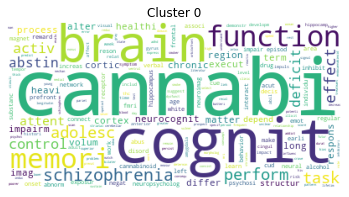

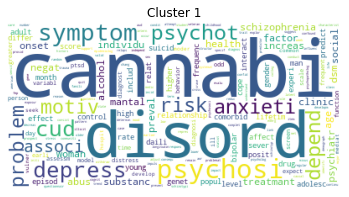

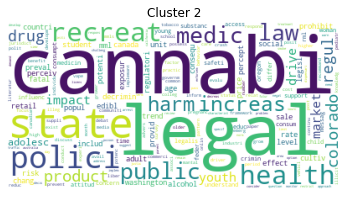

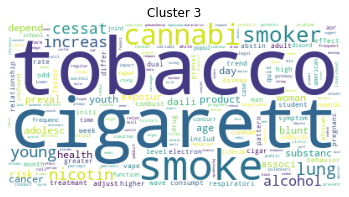

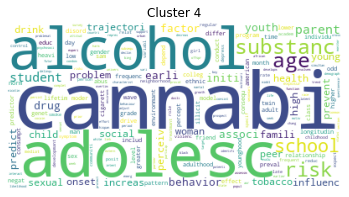

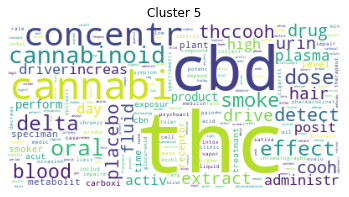

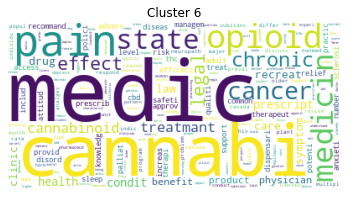

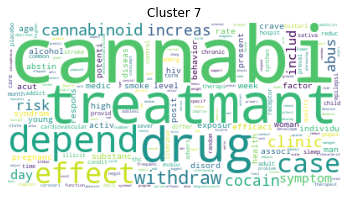

In [99]:
centroids = pd.DataFrame(kmeans_best_result.cluster_centers_)
centroids.columns = tf_final.columns
generateWordClouds(centroids)

[Back to top](#0)

# <a id='10' style=color:black>10. Auto-tagging based on cluster centers</a>

Now that we're satisfied with our clustering we should assign which abstract belongs to which group. <br>
Kmeans algorithm generates cluster labels, which represent the abstracts contained in these clusters. 

In [106]:
# Assigning the cluster labels to each abstract 
df['Category'] = kmeans_best_result.labels_ # the last column you can see the label numebers
df.tail(5)

pubmed_id                                              title  \
7068   15327040  Efficacy, safety and tolerability of an orally...   
7069   32448797  Canadian clinical practice guidelines for the ...   
7070   19201418  Simultaneous ultra-high-pressure liquid chroma...   
7071   25659366  Identification and quantification of 11-nor-9-...   
7072   30528676  Efficacy and safety of a fatty acid amide hydr...   

                                               abstract publication_year  \
7068  OBJECTIVE: Cannabis may alleviate some symptom...             2004   
7069  INTRODUCTION: Chronic pain and co-occurring di...             2020   
7070  An ultra-high-pressure liquid chromatography-t...             2009   
7071  We developed and validated an ultra-high-press...             2015   
7072  BACKGROUND: Cannabis is one of the most widely...             2019   

      Category  
7068         5  
7069         6  
7070         7  
7071         5  
7072         7

### Saving data to CSV file (Optionally)
One can choose to save the dataframe in .csv files for faster access during computational analyses.<br>
We'll use pandas to save the DataFrame to csv file

In [107]:
#df.to_csv('optional_files/abstract_by_cluster.csv')
# Uncomment the following to save the file

### Loading data (Optionally)

We'll use pandas to read the csv file contaning the titles and abstracts for each PMID. 


In [108]:
#df = pd.read_csv('optional_files/abstract_by_cluster.csv')
#df.head()
# Uncomment the following to load cannabis abstracts data

# <a id='11' style=color:black>11. Plotting clusters</a>
Each abstract labeled by number of cluster in the dataframe. To to visualize the K-Means clustering results, we used PCA to reduce the number of dimensions so that we can visualize the results using a 2D Scatter plot. Each cluster represente by different colors.  

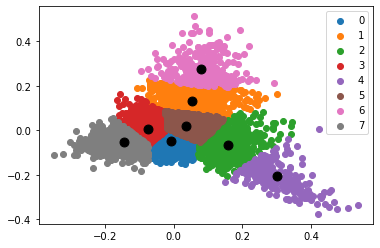

In [109]:
#Load Data
data = tf_final
pca = PCA(2)
 
#Transform the data
dfp = pca.fit_transform(data)
 
#Initialize the class object
kmeans = kmeans_best_result
 
#predict the labels of clusters.
label = kmeans.fit_predict(dfp)

#Getting the Centroids
centroids = kmeans_best_result.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(dfp[label == i , 0] , dfp[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

We can see eight  distinct clusters but with no large separation between them. Clusters which are distant from each other may indicating quite a difference in terms of the content of the abstracts. 

[Back to top](#0)

## Frequency counts

In [110]:
# How many abstracts belong to each cluster -> using group by in pandas
df.groupby(['Category'])['pubmed_id'].count()

Category
0     600
1    1101
2     616
3     386
4    1134
5     497
6     626
7    2113
Name: pubmed_id, dtype: int64

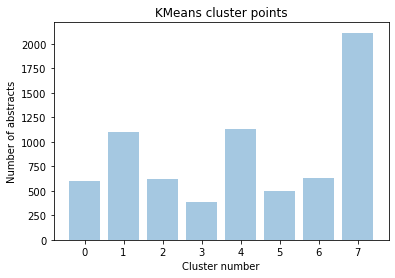

In [111]:
# visually how many abstracts are distributed across 8 clusters 
import matplotlib.pyplot as plt
plt.bar([x for x in range(8)], df.groupby(['Category'])['pubmed_id'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of abstracts")
plt.show()

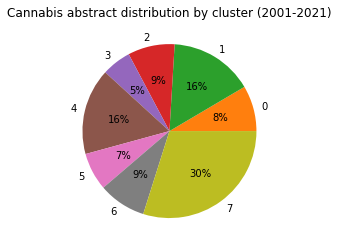

In [112]:
#add colors
colors = ['tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown','tab:pink', 'tab:gray', 'tab:olive']
cmap = plt.get_cmap("tab10")
df.groupby(['Category'])['pubmed_id'].count().plot.pie(colors=colors,autopct='%1.0f%%')
plt.title("Cannabis abstract distribution by cluster (2001-2021)")
plt.ylabel("")
plt.savefig('pie.png')

The first largest cluster is  cannabis addiction treatment (30%) and it is significantly larger than the rest. It is about twice the size of the following two clusters: cannabis use disorder (CUD) (16%) and cannabis use motives (16%). The rest of the clusters are: cannabis policy (9%), medical cannabis (9%), cognitive dysfunction (8%), cannabinoids THC and CBD (7%) and cannabis and tobacco (5%).

[Back to top](#0)

# <a id='12' style=color:black>12. Distribution of clusters over the last 20 years</a>

In [113]:
# Here are some commands to prepere dataframe to be input to the graph of distribution of clusters by years
# group df by year
dfy = df.groupby(['publication_year','Category'])['pubmed_id'].count().to_frame()
dfy.reset_index(inplace=True)
# Create pivot table such as the category will be the variable (columns)
dfy_pv = dfy.pivot_table('pubmed_id', 'publication_year', 'Category')
# Calculate percentage
dfy_pv = dfy_pv.div(dfy_pv.sum(axis=1), axis=0)*100
dfy_pv.reset_index(level=0, inplace=True)
# No abstracts in the category at scpesic year will have zero value 
dfy_pv = dfy_pv.fillna(0)
dfy_pv

Category publication_year          0          1          2         3  \
0                    2001  10.465116  13.953488   3.488372  4.651163   
1                    2002   8.130081  18.699187   2.439024  5.691057   
2                    2003   6.930693   9.900990   1.980198  2.970297   
3                    2004  11.920530  13.907285   5.298013  3.973510   
4                    2005   6.666667  11.515152   3.636364  7.272727   
5                    2006   9.239130  16.304348   1.086957  3.260870   
6                    2007  12.820513  23.589744   2.564103  4.615385   
7                    2008  10.859729  21.266968   1.357466  6.787330   
8                    2009   7.391304  20.000000   3.478261  6.521739   
9                    2010  17.241379  20.258621   2.155172  4.310345   
10                   2011  10.791367  23.021583   2.877698  2.517986   
11                   2012  13.201320  23.102310   2.970297  3.300330   
12                   2013  13.392857  17.261905   1.785714  6.845238   
13                   2014  11.881188  16.831683   7.178218  5.940594   
14                   2015   9.722222  14.484127   7.539683  6.944444   
15                   2016   7.104796  17.939609  12.255773  5.506217   
16                   2017   5.140962  13.266998  14.925373  3.482587   
17                   2018   6.490066  11.788079  13.245033  6.357616   
18                   2019   6.521739  12.077295  14.371981  5.193237   
19                   2020   4.661654  12.481203  13.383459  7.218045   
20                   2021   3.424658   9.589041   9.589041  6.164384   

Category          4         5          6          7  
0         20.930233  8.139535   1.162791  37.209302  
1         19.512195  5.691057   4.065041  35.772358  
2         27.722772  7.920792   7.920792  34.653465  
3         12.582781  8.609272   6.622517  37.086093  
4         19.393939  9.696970   5.454545  36.363636  
5         21.195652  8.695652   4.347826  35.869565  
6         18.974359  5.641026   2.564103  29.230769  
7         18.099548  7.692308   3.167421  30.769231  
8         20.000000  8.695652   5.217391  28.695652  
9         21.120690  6.896552   3.448276  24.568966  
10        19.064748  6.834532   3.597122  31.294964  
11        17.491749  7.260726   4.290429  28.382838  
12        14.583333  8.035714   5.654762  32.440476  
13        15.841584  6.188119   6.188119  29.950495  
14        19.047619  5.357143   8.730159  28.174603  
15        15.097691  6.039076   8.170515  27.886323  
16        15.257048  7.794362  10.281924  29.850746  
17        13.245033  5.960265  14.569536  28.344371  
18        13.768116  6.884058  14.251208  26.932367  
19         9.924812  8.120301  13.533835  30.676692  
20        20.547945  6.164384  10.958904  33.561644

In [114]:
def survey(results, category_names):

    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('tab10')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())
    

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.9,
                label=colname, color=color)
        xcenters = starts + widths / 2


    ax.legend(ncol=1, bbox_to_anchor=(1, 0.5),
              loc='center left', fontsize='large')
    
    return fig, ax


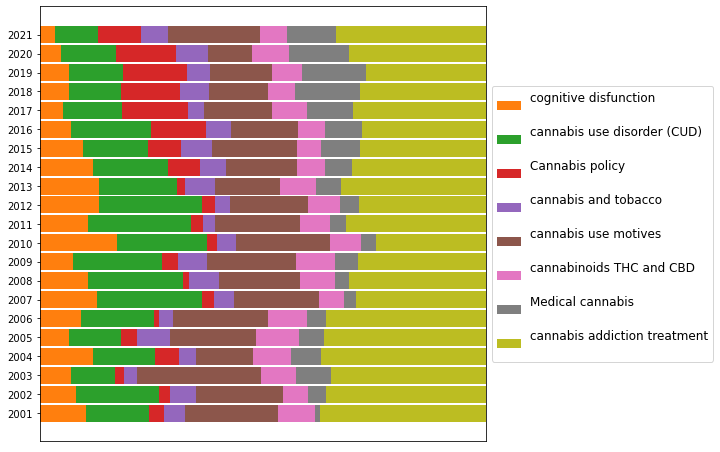

In [115]:
category_names = ['cognitive disfunction\n', 'cannabis use disorder (CUD)\n', 'Cannabis policy\n', 'cannabis and tobacco\n', 'cannabis use motives\n', 'cannabinoids THC and CBD\n', 'Medical cannabis\n', 'cannabis addiction treatment\n']
results = dfy_pv.set_index('publication_year').T.to_dict('list')
key_order = ['2021','2020','2019','2018','2017','2016','2015','2014','2013','2012','2011','2010','2009','2008','2007','2006','2005','2004','2003','2002', '2001']
results = {k : results[k] for k in key_order}

survey(results, category_names)
plt.savefig('bar.png', bbox_inches='tight')
plt.show()

The trend of occurrence of each cluster was plotted against the years that the articles were published. 
<br>
Three groups can be distinguished:<br>
1. Clusters in which no particular trend can be identified over the last 20 years.<br>
These clusters are: cognitive disfunction and cannabis use disorder (CUD)
<br>
2. Clusters in which it can be identified that their relative share over the last 20 years has been declining.<br>
These clusters are: cannabis and tobacco, cannabis use motives, cannabinoids THC and CBD and cannabis addiction treatment.
<br>
3. Clusters in which it can be identified that their relative share over the last 20 years has been rising.<br>
These clusters are: cannabis policy and medical cannabis
<br>

[Back to top](#0)

# <a id='13'>13. Conclusions</a>

In this projet, text analysis and kmeans clustering have been utilized to study and visualize the abstracts fetched from PubMed repository related to cannabis research that published over last 20 years. 
<br><br>
We define eight categories including: cognitive dysfunction, cannabis use disorder (CUD), cannabis policy, cannabis and tobacco, cannabis use motives, cannabinoids THC and CBD, medical cannabis and cannabis addiction treatment. These categories reflect the core themes in existing studies on cannabis.
<br><br>
Comprehensive examination of cannabis research focuses during the last 20 years allow us to identify a trend in the field. Over the last years there is growing in number of studies related to medical cannabis and cannabis policy. This finding reflect the general trend in this field. This trend is likely to continue to rise in the coming years.

[Back to top](#0)